##**AI-Based Student Engagement Detection System**

---



**Mount Google Drive:** Connect Google Drive so we can access the dataset stored in it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Required Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D,
    BatchNormalization, Conv2D, MaxPooling2D, Flatten
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time

**Dataset Configuration**

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/Student-engagement-dataset/train"
test_dir  = "/content/drive/MyDrive/Student-engagement-dataset/test"

**Data Preprocessing & Augmentation**

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1699 images belonging to 6 classes.
Found 421 images belonging to 6 classes.
Found 2120 images belonging to 6 classes.


**-------------------------------------------------------BASELINE MODEL-------------------------------------------------------**

**Build Baseline MobileNetV2 Model**

In [9]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(6, activation="softmax")(x)

baseline_model = Model(inputs=base_model.input, outputs=output)

baseline_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Train Baseline Model**

In [10]:
start = time.time()

history_baseline = baseline_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

baseline_time = time.time() - start

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 675s 12s/step - accuracy: 0.5177 - loss: 1.2441 - val_accuracy: 0.7553 - val_loss: 0.5980
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.8172 - loss: 0.4546 - val_accuracy: 0.8147 - val_loss: 0.4537
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 672ms/step - accuracy: 0.8913 - loss: 0.3056 - val_accuracy: 0.8100 - val_loss: 0.4241
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 668ms/step - accuracy: 0.8846 - loss: 0.2678 - val_accuracy: 0.8314 - val_loss: 0.4080
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 671ms/step - accuracy: 0.8979 - loss: 0.2627 - val_accuracy: 0.8456 - val_loss: 0.3940
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.9122 - loss: 0.2312 - val_accuracy: 0.8480 - val_loss: 0.4117
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 681ms/step - accuracy: 0.9077 - loss: 0.2585 - val_accuracy: 0.8290 - val_loss: 0.3954
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 675ms/step - accuracy: 0.9204 - loss: 0.2025 - val_accur

**Baseline Evaluation**

In [11]:
baseline_loss, baseline_acc = baseline_model.evaluate(test_data)

print(f"Baseline Test Accuracy: {baseline_acc*100:.2f}%")
print(f"Baseline Test Loss: {baseline_loss:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.9375 - loss: 0.1431
Baseline Test Accuracy: 94.43%
Baseline Test Loss: 0.1573


In [12]:
baseline_preds = baseline_model.predict(test_data)
baseline_preds_classes = np.argmax(baseline_preds, axis=1)
y_true = test_data.classes

print(classification_report(
    y_true,
    baseline_preds_classes,
    target_names=test_data.class_indices.keys()
))

67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step
              precision    recall  f1-score   support

Looking Away       1.00      1.00      1.00       423
       bored       0.97      0.75      0.85       358
    confused       1.00      1.00      1.00       369
      drowsy       0.77      0.97      0.86       263
     engaged       1.00      0.94      0.97       347
  frustrated       0.92      1.00      0.96       360

    accuracy                           0.94      2120
   macro avg       0.94      0.94      0.94      2120
weighted avg       0.95      0.94      0.94      2120



**Confusion Matrix**

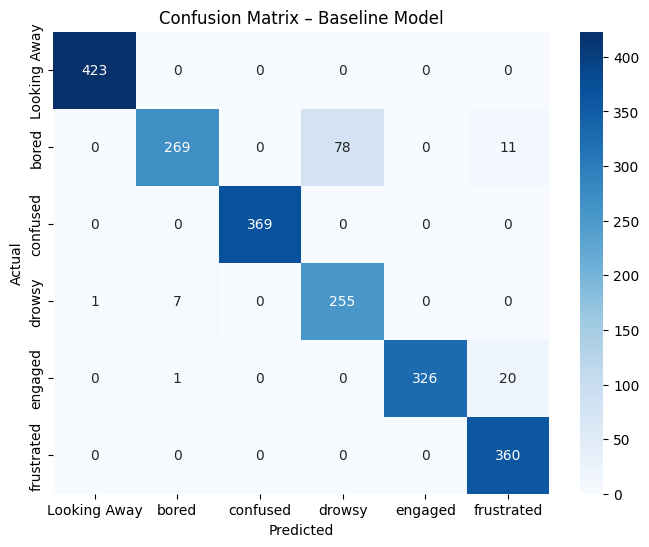

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_baseline = confusion_matrix(y_true, baseline_preds_classes)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_data.class_indices.keys(),
    yticklabels=test_data.class_indices.keys()
)
plt.title("Confusion Matrix – Baseline Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**------------------------------------------------------OPTIMIZED MODEL------------------------------------------------------**

**Build Optimized MobileNetV2 Model**

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(6, activation="softmax")(x)

optimized_model = Model(inputs=base_model.input, outputs=output)

optimized_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Train Optimized Model**

In [23]:
import time

start = time.time()

history_optimized = optimized_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

optimized_time = time.time() - start

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.9447 - loss: 0.1436 - val_accuracy: 0.8646 - val_loss: 0.4297
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 664ms/step - accuracy: 0.9628 - loss: 0.1076 - val_accuracy: 0.8551 - val_loss: 0.4395
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 653ms/step - accuracy: 0.9548 - loss: 0.1403 - val_accuracy: 0.8504 - val_loss: 0.4343
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 669ms/step - accuracy: 0.9561 - loss: 0.1148 - val_accuracy: 0.8694 - val_loss: 0.3552
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9625 - loss: 0.0964 - val_accuracy: 0.8622 - val_loss: 0.4474
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - accuracy: 0.9547 - loss: 0.1155 - val_accuracy: 0.8480 - val_loss: 0.4526
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.9534 - loss: 0.1203 - val_accuracy: 0.8551 - val_loss: 0.4708
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 670ms/step - accuracy: 0.9518 - loss: 0.1175 - val_accu

**Optimized Model Evaluation**

In [25]:
opt_loss, opt_acc = optimized_model.evaluate(test_data)

print(f"Optimized Test Accuracy: {opt_acc*100:.2f}%")
print(f"Optimized Test Loss: {opt_loss:.4f}")


67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.9512 - loss: 0.1316
Optimized Test Accuracy: 95.68%
Optimized Test Loss: 0.1890


**Confusion Matrix**

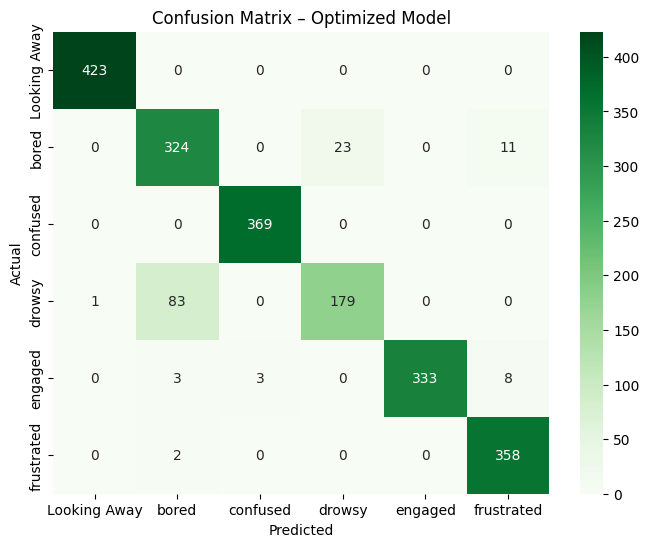

In [ ]:
cm_opt = confusion_matrix(y_true, opt_preds_classes)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=test_data.class_indices.keys(),
    yticklabels=test_data.class_indices.keys()
)
plt.title("Confusion Matrix – Optimized Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**-------------------------------------------COMPARATIVE MODEL (Custom CNN)---------------------------------------------**

**Build CNN Model**



In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(6, activation="softmax")
])

cnn_model.compile(
    optimizer=RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Train CNN Model**

In [ ]:
start = time.time()

history_cnn = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

cnn_time = time.time() - start

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - accuracy: 0.2393 - loss: 2.9588 - val_accuracy: 0.5154 - val_loss: 1.1628
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 644ms/step - accuracy: 0.5495 - loss: 1.1353 - val_accuracy: 0.6342 - val_loss: 0.6902
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 629ms/step - accuracy: 0.6709 - loss: 0.8058 - val_accuracy: 0.6556 - val_loss: 0.7231
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 649ms/step - accuracy: 0.6920 - loss: 0.6993 - val_accuracy: 0.7458 - val_loss: 0.6241
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - accuracy: 0.7381 - loss: 0.5847 - val_accuracy: 0.7696 - val_loss: 0.7115
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 647ms/step - accuracy: 0.7724 - loss: 0.5253 - val_accuracy: 0.7957 - val_loss: 0.5944
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 623ms/step - accuracy: 0.7566 - loss: 0.5221 - val_accuracy: 0.7886 - val_loss: 0.6986
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 648ms/step - accuracy: 0.8044 - loss: 0.4606 - val_accu

**CNN Evaluation**

In [ ]:
cnn_loss, cnn_acc = cnn_model.evaluate(test_data)

print(f"CNN Test Accuracy: {cnn_acc*100:.2f}%")
print(f"CNN Test Loss: {cnn_loss:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.9238 - loss: 0.2319
CNN Test Accuracy: 93.25%
CNN Test Loss: 0.2184


In [ ]:
cnn_preds = cnn_model.predict(test_data)
cnn_preds_classes = np.argmax(cnn_preds, axis=1)

print(classification_report(
    y_true,
    cnn_preds_classes,
    target_names=test_data.class_indices.keys()
))

67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step
              precision    recall  f1-score   support

Looking Away       1.00      1.00      1.00       423
       bored       1.00      0.67      0.80       358
    confused       1.00      1.00      1.00       369
      drowsy       0.71      1.00      0.83       263
     engaged       0.94      1.00      0.97       347
  frustrated       0.97      0.94      0.95       360

    accuracy                           0.93      2120
   macro avg       0.94      0.93      0.92      2120
weighted avg       0.95      0.93      0.93      2120



**Confusion Matrix**

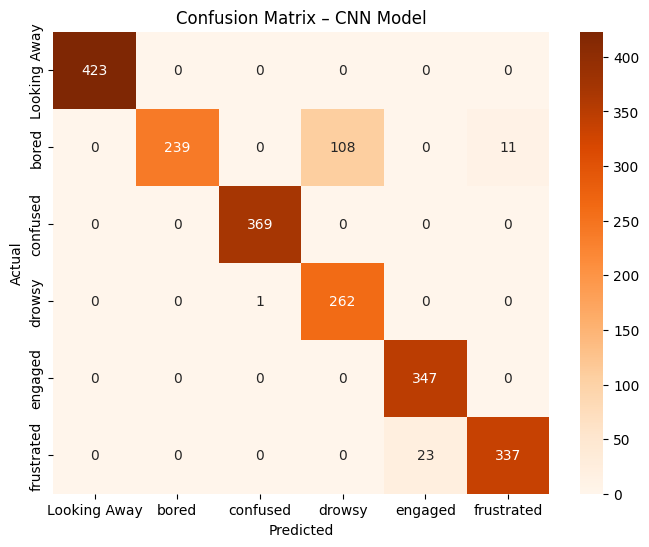

In [ ]:
cm_cnn = confusion_matrix(y_true, cnn_preds_classes)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=test_data.class_indices.keys(),
    yticklabels=test_data.class_indices.keys()
)
plt.title("Confusion Matrix – CNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**-----------------------------------------------Performance Visualization----------------------------------------------------**

**Accuracy & Loss Curves:** Visualize how training and validation accuracy changed over epochs.

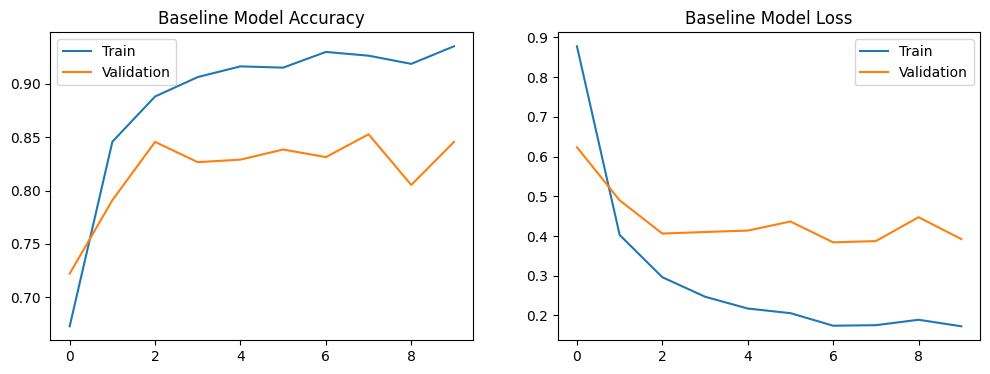

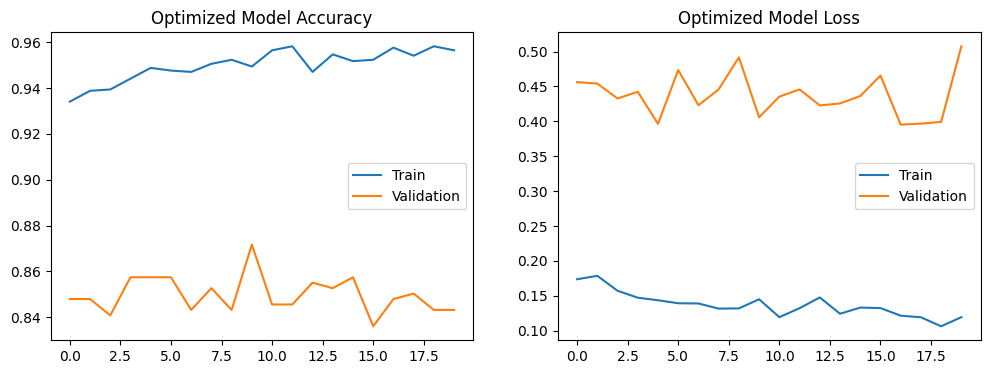

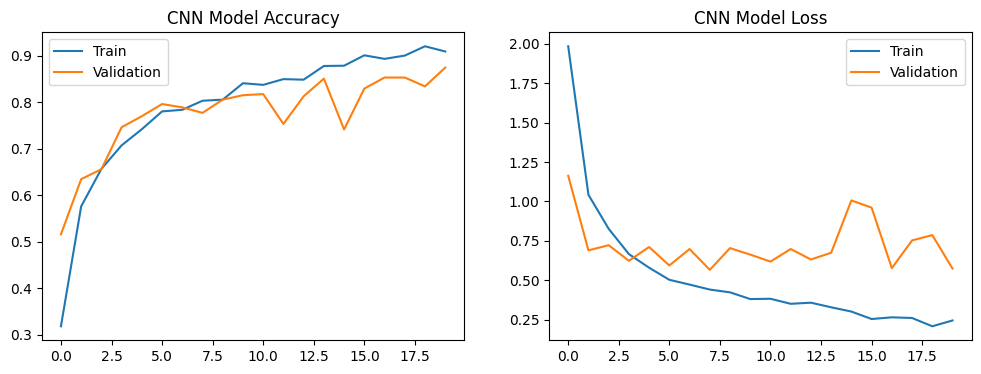

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(f"{title} Accuracy")
    plt.legend(["Train","Validation"])

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"{title} Loss")
    plt.legend(["Train","Validation"])

    plt.show()

plot_history(history_baseline, "Baseline Model")
plot_history(history_optimized, "Optimized Model")
plot_history(history_cnn, "CNN Model")

**--------------------------------------------------Final Quantitative Comparison----------------------------------------------**

In [ ]:
print("Training Time Comparison (seconds)")
print(f"Baseline Model   : {baseline_time:.2f}")
print(f"Optimized Model  : {optimized_time:.2f}")
print(f"CNN Model        : {cnn_time:.2f}")

Training Time Comparison (seconds)
Baseline Model   : 885.58
Optimized Model  : 680.43
CNN Model        : 765.79


**----------------------------------------------------Save all the Models--------------------------------------------------------**

In [ ]:
import os

save_path = "/content/drive/MyDrive/Student-engagement-dataset/models"
os.makedirs(save_path, exist_ok=True)

baseline_model.save(f"{save_path}/baseline_mobilenetv2.keras")
print("Baseline model saved successfully")

Baseline model saved successfully


In [ ]:
optimized_model.save(f"{save_path}/optimized_mobilenetv2.keras")
print("Optimized model saved successfully")

Optimized model saved successfully


In [ ]:
cnn_model.save(f"{save_path}/cnn_model.keras")
print("CNN model saved successfully")

CNN model saved successfully
